In [1]:
import numpy as np
import pandas as pd #to read files or work with dataframes
import yfinance as yf
import datetime as datetime #to specify start and end dates
import matplotlib.pyplot as plt #to visualize
from matplotlib import style
import pandas_datareader as dr #to collect data
from pandas_datareader import data
import cvxpy as cp
import cvxopt as opt
from cvxopt import blas, solvers
import scipy.optimize as sco

%matplotlib inline

In [2]:
#Parameter set up:
n_portfolios = 5000
n_days = 252
assets = ['ETH-GBP', 'BARC.L', 'GSK.L', 'BP.L', 'BATS.L', 'AVV.L']
start_date = '2020-01-01'
end_date = '2022-04-25'

n_assets = len(assets)

In [3]:
#Downloading stockprices from Yahoo Finance:
prices = yf.download(assets, start=start_date, end=end_date, adjusted=True)

[*********************100%***********************]  6 of 6 completed


In [4]:
#Calculation of Annualised Average Returns and the corresponding Standard Deviation:
returns = prices['Adj Close'].pct_change().dropna()
returns

,AVV.L,BARC.L,BATS.L,BP.L,ETH-GBP,GSK.L
Date,,,,,,
2020-01-03,-0.004243,-0.010259,0.026646,0.027451,0.058423,0.004051
2020-01-04,0.000000,0.000000,0.000000,0.000000,0.006690,0.000000
2020-01-05,0.000000,0.000000,0.000000,0.000000,0.009093,0.000000
2020-01-06,-0.003835,-0.012657,-0.000597,0.020342,0.051429,-0.007846
2020-01-07,0.010265,0.011935,0.016716,-0.010514,-0.000803,-0.004519
...,...,...,...,...,...,...
2022-04-20,0.015696,0.021826,0.011291,0.000249,-0.012589,-0.010684
2022-04-21,0.025214,0.007926,0.009203,0.004986,-0.026162,0.002298
2022-04-22,-0.000793,-0.022391,-0.001495,-0.024805,0.006721,-0.001605


In [5]:
avg_returns = returns.mean()* n_days
avg_returns

AVV.L     -0.057568
BARC.L     0.028847
BATS.L     0.083654
BP.L       0.052220
ETH-GBP    1.279780
GSK.L      0.048683
dtype: float64

In [6]:
cov_mat = returns.cov() * n_days
cov_mat

,AVV.L,BARC.L,BATS.L,BP.L,ETH-GBP,GSK.L
AVV.L,0.111612,0.041470,0.017948,0.035564,0.046345,0.020725
BARC.L,0.041470,0.151199,0.034879,0.092798,0.048454,0.021396
BATS.L,0.017948,0.034879,0.051652,0.039182,0.012425,0.021434
BP.L,0.035564,0.092798,0.039182,0.143664,0.032932,0.025846
ETH-GBP,0.046345,0.048454,0.012425,0.032932,0.650818,0.016394
GSK.L,0.020725,0.021396,0.021434,0.025846,0.016394,0.036762


In [7]:
prices = pd.DataFrame()
for tick in assets:
    prices[tick] = data.DataReader(tick, data_source='yahoo', start='2020-01-01', end='2022-04-25')['Adj Close']
prices.columns = assets
    
prices

,ETH-GBP,BARC.L,GSK.L,BP.L,BATS.L,AVV.L
Date,,,,,,
2020-01-01,98.714050,NaN,NaN,NaN,NaN,NaN
2020-01-02,96.912010,171.548996,1574.029663,414.027344,2752.842773,3688.335449
2020-01-03,102.573875,169.789062,1580.406494,425.392883,2826.195312,3672.687012
2020-01-04,103.260132,NaN,NaN,NaN,NaN,NaN
2020-01-05,104.199127,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-04-22,2309.153320,146.699997,1742.000000,388.037811,3339.500000,2519.000000
2022-04-23,2288.341309,NaN,NaN,NaN,NaN,NaN
2022-04-24,2278.340332,NaN,NaN,NaN,NaN,NaN


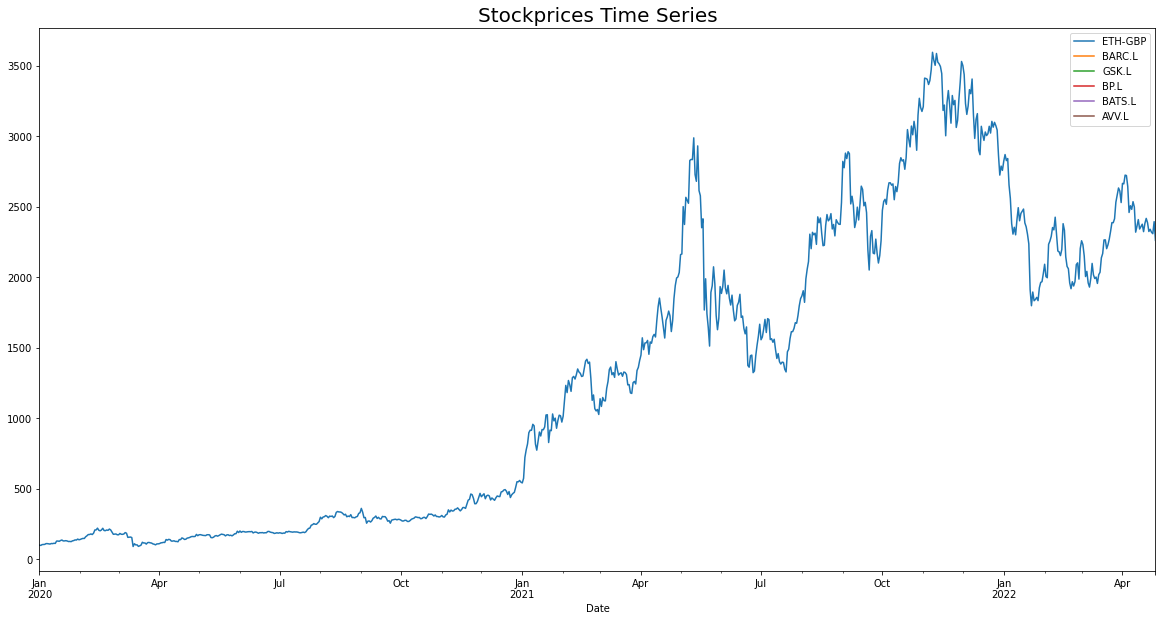

In [8]:
# Plotting the timeseries:
timeseries = prices / prices.iloc[0] * 100
timeseries.plot(figsize=(20, 10))
plt.title('Stockprices Time Series', fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

In [9]:
#Simulation of random portfolio weights:
np.random.seed(42)
weights = np.random.random(size=(n_portfolios, n_assets))
weights /= np.sum(weights, axis=1) [:, np.newaxis]
weights

array([[0.12619616, 0.32033016, 0.24663533, 0.20170978, 0.05256834,
        0.05256022],
       [0.01801633, 0.26866992, 0.18645344, 0.21962946, 0.00638488,
        0.30084597],
       [0.37179051, 0.09483616, 0.08120775, 0.08191322, 0.13588249,
        0.23436986],
       ...,
       [0.27840367, 0.24013169, 0.05023938, 0.19749468, 0.20429738,
        0.02943319],
       [0.20681893, 0.11573745, 0.20740701, 0.34502156, 0.07026766,
        0.05474739],
       [0.10173348, 0.35971915, 0.28248832, 0.00734939, 0.15147836,
        0.0972313 ]])

In [10]:
portf_returns = np.dot(weights, avg_returns)

portf_vol = np.diag(np.sqrt(np.dot(weights, np.dot(cov_mat, weights.T))))
portf_vol = np.array(portf_vol)
portf_sharpe_ratio = portf_returns / portf_vol

In [11]:
portf_results = pd.DataFrame({'returns': portf_returns,
                             'volatility': portf_vol,
                             'sharpe_ratio': portf_sharpe_ratio})
portf_results

,returns,volatility,sharpe_ratio
0,0.102976,0.247627,0.415851
1,0.056597,0.226614,0.249752
2,0.177713,0.234856,0.756688
3,0.203335,0.220433,0.922436
4,0.308546,0.305165,1.011080
...,...,...,...
4995,0.167689,0.262686,0.638361
4996,0.161998,0.257489,0.629147
4997,0.268304,0.291237,0.921257
4998,0.119392,0.243238,0.490846


In [12]:
n_points = 20
portf_vol_ef = []
indices_to_skip = []

portf_returns_ef = np.linspace(portf_results.returns.min(),
                               portf_results.returns.max(),
                               n_points)
portf_rerturns_ef = np.round(portf_returns_ef, 2)
portf_returns = np.round(portf_returns, 2)

for point_index in range (n_points):
    if portf_returns_ef[point_index] not in portf_returns:
       indices_to_skip.append(point_index)
       continue
    matched_ind = np.where(portf_returns ==
                           portf_returns_ef[point_index])
    
portf_returns_ef = np.delete(portf_returns_ef, indices_to_skip)

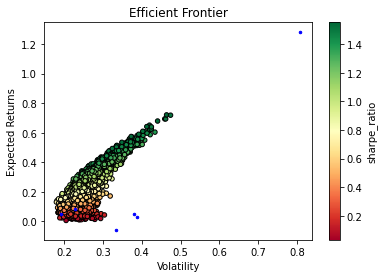

In [13]:
marks = ['.', '.', '.', '.', '.', '.']


fig, ax = plt.subplots()
portf_results.plot(kind='scatter', 
                   x='volatility', 
                   y='returns', 
                   c='sharpe_ratio', 
                   cmap='RdYlGn', 
                   edgecolors='black', 
                   ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_returns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]),
               y=avg_returns[asset_index],
               marker=marks[asset_index],
               s=25,
               color='blue',
               label=())

In [14]:
max_sharpe_ind = np.argmax(portf_results.sharpe_ratio)
max_sharpe_portf = portf_results.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results.volatility)
min_vol_portf = portf_results.loc[min_vol_ind]

In [15]:
print ('Maximum Sharpe Ratio portfolio ----')
print ('Performance')
for index, value in max_sharpe_portf.items() :
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(assets,
weights[np.argmax(portf_results.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 72.07% volatility: 46.39% sharpe_ratio: 155.35% 
Weights
ETH-GBP: 2.83% BARC.L: 9.32% GSK.L: 23.96% BP.L: 8.17% BATS.L: 54.27% AVV.L: 1.44% 

In [16]:
print ('Minimum Volatility portfolio ----')
print ('Performance')
for index, value in min_vol_portf.items() :
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(assets,
weights[np.argmin(portf_results.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: 13.10% volatility: 18.04% sharpe_ratio: 72.64% 
Weights
ETH-GBP: 40.23% BARC.L: 4.98% GSK.L: 2.90% BP.L: 6.89% BATS.L: 0.02% AVV.L: 44.99% 

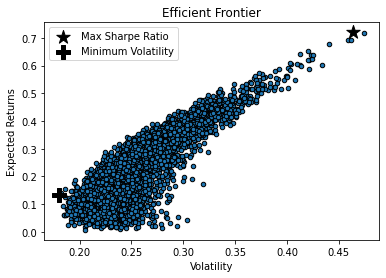

In [17]:
fig, ax = plt.subplots()
portf_results.plot(kind='scatter',
                   x='volatility',
                   y='returns',
                   cmap='RdYlGn',
                   edgecolors='black',
                   ax=ax)
ax.scatter(x=max_sharpe_portf.volatility,
           y=max_sharpe_portf.returns,
           c='black',
           marker='*',
           s=200,
           label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility,
           y=min_vol_portf.returns,
           c='black',
           marker='P',
           s=200,
           label='Minimum Volatility')
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')
ax.legend()

In [18]:
# Define functions for calculating portfolio return and volatility:

def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [19]:
# Define the function calculating theEfficient Frontier:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    efficient_portfolios = []
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range (n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    for ret in rtns_range:
        constraints = ({'type': 'eq',
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq',
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol,
                                           initial_guess,
                                           args=args,
                                           method='SLSQP',
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    return efficient_portfolios

In [20]:
# Define the considered range of returns
rtns_range = np.linspace (0.1, 0.32, 200)

In [21]:
# Calculate the Efficient Frontier
efficient_portfolios = get_efficient_frontier(avg_returns,
                                              cov_mat,
                                              rtns_range)

In [22]:
# Extract the volatilities of the efficient portfolios:
vols_range = [x['fun'] for x in efficient_portfolios]

[Text(0.5, 0, 'Volatility'),
 Text(0, 0.5, 'Expected Returns'),
 Text(0.5, 1.0, 'Efficient Frontier')]

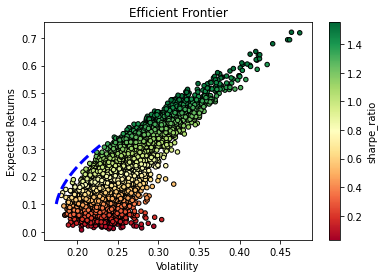

In [23]:
# Plot the calculated Efficient Frontier, together with the simulated portfolios:
fig, ax = plt.subplots()
portf_results.plot(kind='scatter',
                   x='volatility',
                   y='returns',
                   c='sharpe_ratio',
                   cmap='RdYlGn',
                   edgecolors='black',
                   ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')

In [24]:
# Identify the minimum volatility portfolio:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Voltatility': min_vol_portf_rtn,
                 'Sharpe Ratio': (min_vol_portf_rtn /
                                  min_vol_portf_vol)}

In [25]:
# Print the performance summary:
print ('Minimum volatility portfolio ----')
print ('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
    
print('\nWeights')
for x, y in zip (assets,
efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum volatility portfolio ----
Performance
Return: 10.00% Voltatility: 10.00% Sharpe Ratio: 57.40% 
Weights
ETH-GBP: 8.22% BARC.L: 1.03% GSK.L: 30.57% BP.L: 0.00% BATS.L: 4.03% AVV.L: 56.16% 

In [26]:
# Define the objective function for the negative Sharpe Ratio:

def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate) :
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
    return -portf_sharpe_ratio

In [27]:
# Finding the optimized portfolio:
n_assets = len(avg_returns)
rf_rate = 0.01

args = (avg_returns, cov_mat, rf_rate)
constraints = ({'type': 'eq',
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range (n_assets))
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio,
                                x0=initial_guess,
                                args=args,
                                method='SLSQP',
                                bounds=bounds,
                                constraints=constraints)

In [28]:
# Extracting information about the maximu Sharpe Ratio portfolio:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w,
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w, 
                                            avg_returns,
                                            cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}

In [29]:
# Printing performance summary:
print ('Maximum Sharpe Ratio portfolio ----')
print ('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100*value:.2f}% ', end="", flush=True)
    
print('\nWeights')
for x, y in zip (assets, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
Return: 88.23% Volatility: 54.90% Sharpe Ratio: 158.90% 
Weights
ETH-GBP: 0.00% BARC.L: 0.00% GSK.L: 33.23% BP.L: 0.00% BATS.L: 66.77% AVV.L: 0.00% 

In [30]:
# Convert the annualised average returns and the covariance matrix to numpy arrays:
avg_returns = avg_returns.values
cov_mat = cov_mat.values

In [31]:
# Set up the optimization problem
weights = cp.Variable(n_assets)
gamma = cp.Parameter(nonneg=True)
portf_rtn_cvx = avg_returns @ weights
portf_vol_cvx = cp.quad_form(weights, cov_mat)
objective_function = cp.Maximize(portf_rtn_cvx - gamma * portf_vol_cvx)
problem = cp.Problem(objective_function,
                     [cp.sum(weights) == 1, weights>= 0])

In [32]:
# Calculate the Efficient Frontier
n_points = 20
portf_rtn_cvx_ef = np.zeros(n_points)
portf_vol_cvx_ef = np.zeros(n_points)
weights_ef = []
gamma_range = np.logspace(-3, 3, num=n_points)

for i in range (n_points) :
    gamma.value = gamma_range[i]
    problem.solve()
    portf_vol_cvx_ef[i] = cp.sqrt(portf_vol_cvx).value
    portf_rtn_cvx_ef[i] = portf_rtn_cvx.value
    weights_ef.append(weights.value)

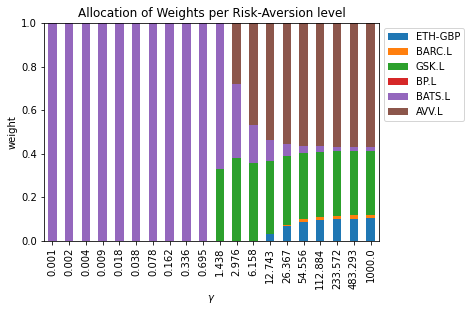

In [33]:
# Plot the allocation for different values of the risk-aversion parameter
weights_df = pd.DataFrame(weights_ef,
                          columns=assets,
                          index=np.round(gamma_range, 3))
ax = weights_df.plot(kind='bar', stacked=True)
ax.set(title='Allocation of Weights per Risk-Aversion level',
       xlabel=r'$\gamma$',
       ylabel='weight')
ax.legend(bbox_to_anchor=(1,1))

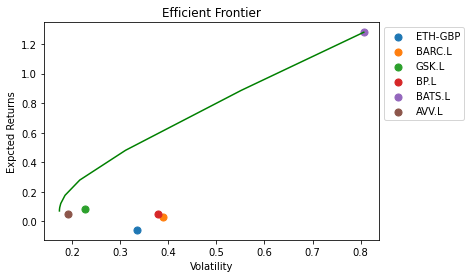

In [34]:
# Plotting the Efficient Frontier with individual assets
MARKS = ['.', '.', '.', '.', '.', '.']

fig, ax = plt.subplots()
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-')
for asset_index in range(n_assets):
     plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]),
                 y=avg_returns[asset_index],
                 marker=MARKS[asset_index],
                 label=assets[asset_index],
                 s=200)
ax.set(title='Efficient Frontier',
       xlabel='Volatility',
       ylabel='Expcted Returns', )
ax.legend(bbox_to_anchor=(1,1))

[Text(0.5, 1.0, 'Maximized Risk-Adjusted Retrun'),
 Text(0.5, 0, 'Volatility'),
 Text(0, 0.5, 'Expected Returns'),
 (0.1, 0.5),
 (0.1, 0.75)]

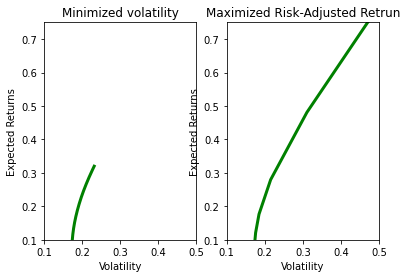

In [35]:
# Efficient frontier comparison
x_lim = [0.1, 0.5]
y_lim = [0.1, 0.75]

fig, ax = plt.subplots(1, 2)
ax[0].plot(vols_range, rtns_range, 'g-', linewidth=3)
ax[0].set(title='Minimized volatility',
          xlabel='Volatility',
          ylabel='Expected Returns',
          xlim=x_lim,
          ylim=y_lim)

ax[1].plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-', linewidth=3)
ax[1].set(title='Maximized Risk-Adjusted Retrun',
          xlabel='Volatility',
          ylabel='Expected Returns',
          xlim=x_lim,
          ylim=y_lim)

In [36]:
# Analysing maximum allowable leverage
max_leverage= cp.Parameter()
problem_with_leverage = cp.Problem(objective_function,
                                   [cp.sum(weights) == 1,
                                    cp.norm(weights, 1) <= max_leverage])

In [37]:
# Redefining objects in order to store the results to be either larger 2D matrices or 3 = [1, 2, 5]
leverage_range = [1, 3, 5]
len_leverage = len(leverage_range)
n_points = 20

portf_vol_l_ef = np.zeros((n_points, len_leverage))
portf_rtn_l_ef = np.zeros((n_points, len_leverage))
weights_ef =np.zeros((len_leverage, n_points, n_assets))

for lev_ind, leverage in enumerate(leverage_range) :
    for gamma_ind in range(n_points):
        max_leverage.value = leverage
        gamma.value = gamma_range[gamma_ind]
        problem_with_leverage.solve(verbose=True)
        portf_vol_l_ef[gamma_ind, lev_ind] = cp.sqrt(portf_vol_cvx).value
        portf_rtn_l_ef[gamma_ind, lev_ind] = portf_rtn_cvx.value
        weights_ef[lev_ind, gamma_ind, :] = weights.value

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) May 16 07:22:39 AM: Your problem has 6 variables, 2 constraints, and 2 parameters.
(CVXPY) May 16 07:22:39 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 16 07:22:39 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 16 07:22:39 AM: Compiling problem (target solver=OSQP).
(CVXPY) May 16 07:22:39 AM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) May 16 07:22:39 AM: Applying reduction FlipObjective
(CVXPY) May 16 07:22:39 AM: Applying reduction

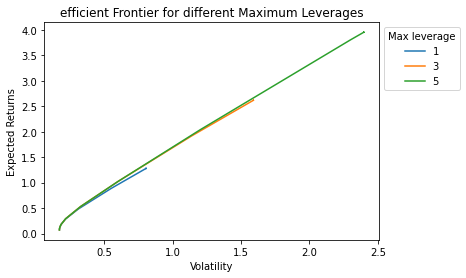

In [38]:
# Efficient frontiers for dfferent maximum leverages
fig, ax=plt.subplots()

for leverage_index, leverage in enumerate(leverage_range):
    plt.plot(portf_vol_l_ef[:, leverage_index],
            portf_rtn_l_ef[:, leverage_index],
            label=f'{leverage}')
    
ax.set(title='efficient Frontier for different Maximum Leverages',
       xlabel='Volatility',
       ylabel='Expected Returns')
ax.legend(title='Max leverage',
          bbox_to_anchor=(1,1))

Text(0.5, 1.0, 'Weights allocation per risk-aversion level')

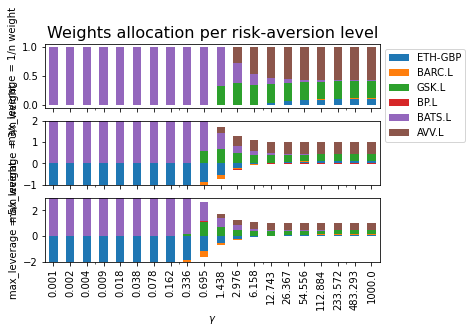

In [39]:
# Plotting weight allocation per varying risk-aversion levels
fig, ax = plt.subplots(len_leverage, 1, sharex=True)

for ax_index in range(len_leverage):
    weights_df = pd.DataFrame (weights_ef[ax_index],
                               columns=assets,
                               index=np.round(gamma_range, 3))
    weights_df.plot(kind='bar',
                    stacked=True,
                    ax=ax[ax_index],
                    legend=None)
    ax[ax_index].set(ylabel=(f'max_leverage = {leverage_range[ax_index]}'
                             '/n weight'))
    
ax[len_leverage - 1].set(xlabel=r'$\gamma$')
ax[0].legend(bbox_to_anchor=(1,1))
ax[0].set_title('Weights allocation per risk-aversion level',
                fontsize=16)